## About
Generates small fluctuations about a given structure (usually the crystal structure) to seed the simulation.<br/>
**Important:** The code will write a file called `perturbed_poses.out` in your `ROOT_DIR` folder (you will select this below). To seed the TM run with these structures, go to the `data/rosetta` folder in your TM submit directory (the submit directory is the folder with `TMaMD.py`) and remove ALL files. Then, copy the `perturbed_poses.out` file as *{name}_job1.out*, where {name} is the name you chose for your job in the config file for this run.<br/>
Comment out the 3 rosetta generation lines as usual in `TMaMD.py`
- `# args = cfg.compile(subsections=["rosetta.mc_sample_args"], as_args=True, leaves=True)`
- `# driver = rosetta.mc_sample(args)`
- `# driver.wait()`

and submit the job

**Note:** Some parts of this code may be sensitive to the RNA chosen/your computer system. These regions are marked out with a <i>'#TODO: Change accordingly'</i> tag<br/>
**Also note:** All output files will be saved to your selected `ROOT_DIR`

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
%run ../PyRosetta/General.ipynb
%run ../PyRosetta/RNAFolder.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org



In [3]:
ROOT_DIR = "/home/venkata/python/PyRosetta/R1107/server/example_tut/" # TODO: Change accordingly

true_pose=LoadedPDB(ROOT_DIR+"/../../7qr4_clean_noprotein.pdb") # TODO: Change accordingly (Path to crystal structure)
new_pose=LoadedPDB(ROOT_DIR+"/../../7qr4_clean_noprotein.pdb") # TODO: Change accordingly (Path to crystal structure, making a copy)
true_seq=true_pose.sequence()

scorefxn = pyrosetta.rosetta.core.scoring.ScoreFunctionFactory.create_score_function("rna/denovo/rna_hires");
scorefxn(true_pose) # Should be negative

-152.12682711052625

In [8]:
N_PERT=1000 # TODO: Change accordingly (No. of structures to generate. Note that this is more like a parameter. Many will fail due to clashes. Pick 2-3 times your true target value)

perts=generate_random_perturbations(new_pose,k=N_PERT)
poses=[]
for i,p in enumerate(perts):
    # Apply a small perturbation to the pose
    new_pose=p.apply(new_pose)

    # Check if there are no clashes (score is used as a proxy. Negative score will likely imply no clashes)
    if scorefxn(new_pose)<0:
        poses.append(new_pose.clone())
    
    # Reverse the perturbation (next iteration will start back from crystal structure)
    new_pose=p.apply(new_pose,inverse=True)
    if (i+1)%50==0: print(i+1,"of",N_PERT)

# Save all the poses till now
pyrosetta.poses_to_silent(poses,ROOT_DIR+"/perturbed_poses.out")
print("Saved to",ROOT_DIR+"/perturbed_poses.out")
print("A total of",len(poses),"poses constructed") # The actual number of poses made
#new_pose.dump_pdb("R1107/random_pose.pdb")

50 of 1000
100 of 1000
150 of 1000
200 of 1000
250 of 1000
300 of 1000
350 of 1000
400 of 1000
450 of 1000
500 of 1000
550 of 1000
600 of 1000
650 of 1000
700 of 1000
750 of 1000
800 of 1000
850 of 1000
900 of 1000
950 of 1000
1000 of 1000
Saved to /home/venkata/python/PyRosetta/R1107/server/example_tut//perturbed_poses.out
A total of 400 poses constructed


In [11]:
resolved_rmsds=[]
for i,pose in enumerate(poses):
    aligned_pose=align_poses(true_pose,pose,silent=True)
    rmsdval=get_rmsd(true_pose,pose)
    resolved_rmsds.append(rmsdval)
    if (i+1)%50==0: print(i+1,"of",len(poses))
resolved_rmsds=np.array(resolved_rmsds)
np.save(ROOT_DIR+"/perturbed_rmsds.npy",resolved_rmsds)

50 of 400
100 of 400
150 of 400
200 of 400
250 of 400
300 of 400
350 of 400
400 of 400


(array([1]), [])

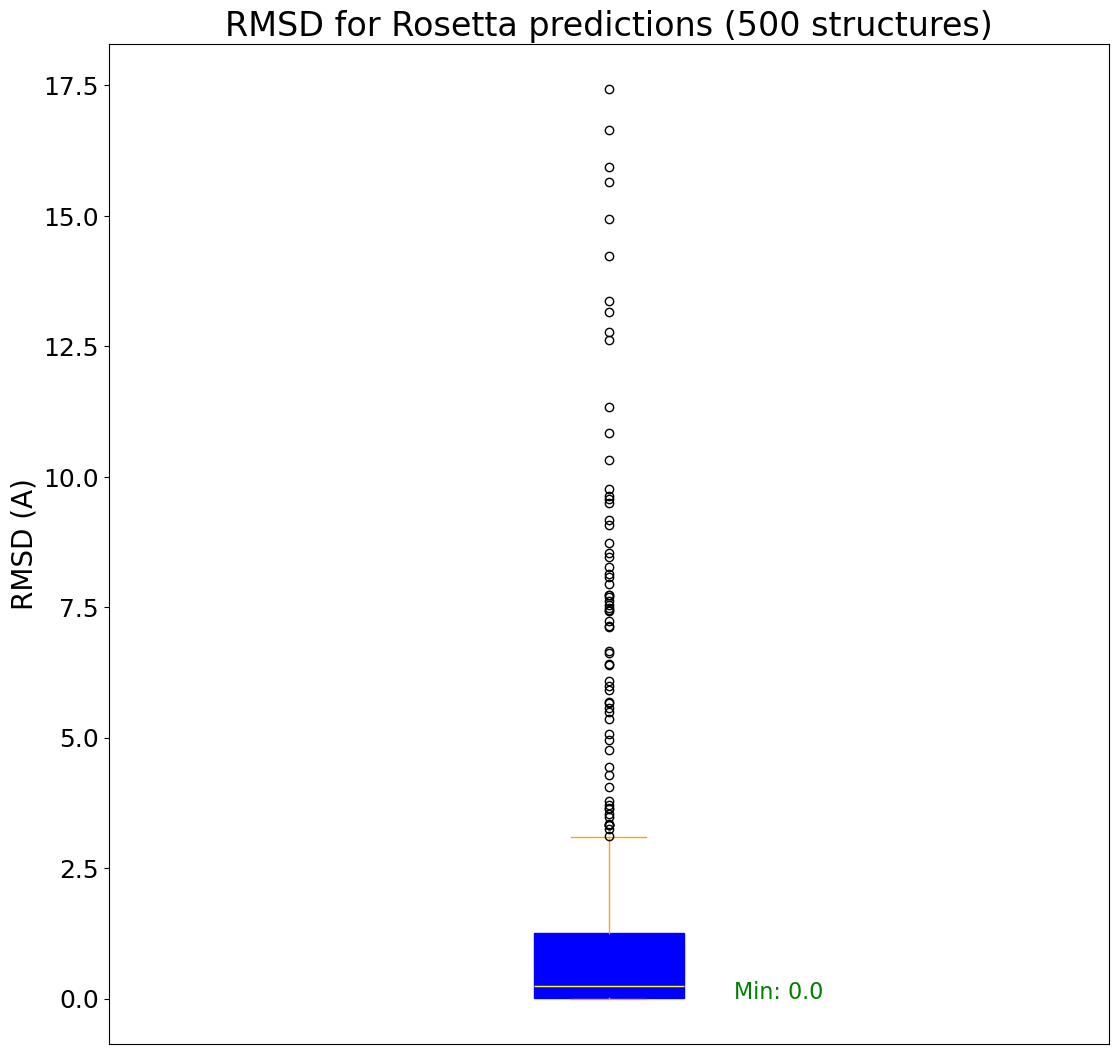

In [18]:
# See the RMSD distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = plt.axes((0, 0, 1, 1))
ax.text(1.125,np.min(resolved_rmsds), "Min: "+str(round(np.min(resolved_rmsds),2)), fontsize=16, color='green')
bplot=plt.boxplot(resolved_rmsds,patch_artist=True,notch=False)
bplot["boxes"][0].set_color("blue")
bplot["medians"][0].set_color("yellow")
[whisk.set_color("orange") for whisk in bplot["whiskers"]]
[whisk.set_color("orange") for whisk in bplot["caps"]]

plt.title("RMSD for Rosetta predictions (500 structures)",fontsize=24)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.yticks(fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.xticks()

In [13]:
from pyrosetta.rosetta.core.io.pdb import add_to_multimodel_pdb

# Saves everything as a PDB
combined_pdb=ROOT_DIR+"/perturbed_poses.pdb"
for i,pose in enumerate(poses,start=1):
    model_tag = f"MODEL_{i}"
    add_to_multimodel_pdb(pose, combined_pdb, model_tag)